<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from numpy.random import seed
seed(1234)

In [3]:
import numpy as np
from sklearn import manifold
from apricot import FacilityLocationSelection
from apricot import FeatureBasedSelection
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import umap
from sklearn.manifold import TSNE

In [4]:
from sklearn.decomposition import PCA
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [5]:
import locusselect 
from locusselect.embeddings import * 
from locusselect.deeplift import * 
from locusselect.utils import *
import os
import pickle
from pybedtools import BedTool

Using TensorFlow backend.


In [6]:
def umap_transform(peak_data, n_components=3, random_state=25, metric = 'correlation',n_neighbors=15,min_dist=0.1):
    umap_obj = umap.UMAP(n_components=n_components, random_state=random_state,
        min_dist=min_dist,metric=metric,n_neighbors=n_neighbors)
    try:
        umap_res = umap_obj.fit_transform(peak_data.toarray())
    except:
        umap_res = umap_obj.fit_transform(peak_data)
    return umap_res

In [7]:
def performEmbeddings ( data_list, n_components=2, random_state=2, metric= 'correlation' ) :
    embedding_list = []; 
    for data in data_list :
        embedding_list.append( umap_transform(data, n_components=2, random_state=2,metric=distanceMeasure) )
    return (embedding_list)

In [8]:
def makeGeneralAnnotation ( Ind_list, label_list, k ) :
    num_labels = np.zeros(k)
    
    label_dict = { 'All' : 0 }
    for i in range(len(Ind_list)) :
        num_labels[Ind_list[i]] = i + 1
        label_dict[label_list[i]] = i + 1
    return (num_labels, label_dict)

In [9]:
def plot_embedding_2d(embedding, num_labels=None, label_dict=None, s_dict=None, a_dict=None, cmap=None, norm=None, title='' ):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    if num_labels is None or label_dict is None :
        scatter_res = ax.scatter(embedding[:,0], embedding[:,1], s=4, alpha=1)

    else :
        for label in label_dict.keys() :
            Ind = np.where(num_labels == label_dict[label])[0]
            color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
            if s_dict is None : 
                dotsize = 4 
            else : 
                dotsize = s_dict[label]
            if a_dict is None : 
                alpha = 1
            else : 
                alpha = a_dict[label]
            scatter_res = ax.scatter(embedding[Ind,0], embedding[Ind,1], s=dotsize, alpha=alpha,c=color, label=label)
        ax.set_xlim( min(embedding[:,0]) - ( ( max(embedding[:,0]) - min(embedding[:,0]) ) * 0.5 ), max(embedding[:,0]) )
        ax.set_ylim( min(embedding[:,1]), max(embedding[:,1]) + ( ( max(embedding[:,1]) - min(embedding[:,1]) ) * 0.5 ) )
        ax.set_title(title)
        ax.legend(loc='upper left',prop={'size': 12})

In [10]:
def selectSubset ( data_matrix, n = None, distance = 'euclidean', initial_subset = None, selection_subset = None ) :
    if selection_subset is not None :
        data_matrix = data_matrix[selection_subset]
    
    if n is None :
        n = np.shape(data_matrix)[0]
    
    if initial_subset is None :
        model = FacilityLocationSelection(n, distance)
    else :
        model = FacilityLocationSelection(n, distance, initial_subset = initial_subset )
    
    Xi = model.fit_transform(data_matrix)
    SubsetInd = model.ranking
    Gains = model.gains
    
    if selection_subset is not None :
        SubsetInd = selection_subset[SubsetInd]
    
    return SubsetInd, Gains

In [11]:
def makeBed(labels) :
    chrNames = np.array([ (coords.decode()).split('_')[0] for coords in labels ] )
    starts = np.array ([ int((coords.decode()).split('_')[1]) for coords in labels ] )
    ends = np.array ([ int((coords.decode()).split('_')[2]) for coords in labels ] )
    
    table = np.zeros(len(chrNames), dtype={'names':('f0', 'f1', 'f2'),'formats':('S5', 'i4', 'i4')})
    table['f0'] = chrNames; table['f1'] = starts+1; table['f2'] = ends;
    return(table)

In [12]:
def intersectBeds ( bed1, bed2, pickLargestOverlap = True ) :
    chrs1 = np.unique(bed1['f0']);  chrs2 = np.unique(bed2['f0'])
    allchrs = np.intersect1d(chrs1,chrs2)
    overlapInd1 = []; overlapInd2 = []; overlapLen = []
    for chr in allchrs :
        Ind1 = np.where(bed1['f0']==chr)[0];    Ind2 = np.where(bed2['f0']==chr)[0]
        midPoint1 = ( bed1['f2'][Ind1] + bed1['f1'][Ind1] ) / 2
        midPoint2 = ( bed2['f2'][Ind2] + bed2['f1'][Ind2] ) / 2
        int1 = bed1['f2'][Ind1] - bed1['f1'][Ind1] + 1
        int2 = bed2['f2'][Ind2] - bed2['f1'][Ind2] + 1
        maxInt = 2 * np.max(np.append(int1,int2))
        for I in range(len(Ind1)) :
            dist = np.abs( midPoint1[I] - midPoint2 )
            closeInd = Ind2[ np.where( dist < maxInt )[0] ]
            if len(closeInd) > 0 :
                for I2 in closeInd :
                    maxStart = max(bed1[Ind1[I]][1], bed2[I2][1])
                    minEnd = min(bed1[Ind1[I]][2], bed2[I2][2])
                    if maxStart < minEnd:
                        overlapInd1.append(Ind1[I])
                        overlapInd2.append(I2)
                        overlapLen.append(minEnd-maxStart)
                        
    overlapInd1 = np.array(overlapInd1); overlapInd2 = np.array(overlapInd2); overlapLen = np.array(overlapLen)
    
    uniqueOverlapInd1 = []; uniqueOverlapInd2 = []; uniqueOverlapLen = []
    if pickLargestOverlap == True :
        uniqueOI1 = np.unique(overlapInd1)
        for uI in uniqueOI1 :
            Ind = np.where(overlapInd1==uI)[0]
            Ord = np.argsort(overlapLen[Ind])
            uniqueOverlapInd1.append(uI); uniqueOverlapInd2.append(overlapInd2[Ind[Ord[-1]]]);
            uniqueOverlapLen.append(overlapLen[Ind[Ord[-1]]])
    
    uniqueOverlapInd1 = np.array(uniqueOverlapInd1); uniqueOverlapInd2 = np.array(uniqueOverlapInd2)
    uniqueOverlapLen = np.array(uniqueOverlapLen)
    
    return (uniqueOverlapInd1,uniqueOverlapInd2,uniqueOverlapLen)

In [13]:
def get_embedding_data_list_fc(bed_list, layer):

    dl_fc_data_list = []
    
    for bed_file in bed_list:
        
        print(bed_file)
        print(layer)
        
        all_fc_embeddings = []

        fc_embedding_args={"input_bed_file":bed_file,
                   "model_hdf5":"/data/locusselect/k562_dnase_dl_models/k562_regression/DNASE.K562.regressionlabels.allbins.0",
                   "ref_fasta":"/data/refs/hg19/male.hg19.fa",
                   "center_on_summit":True,
                   "flank":500,
                   "embedding_layer":layer,
                   "expand_dims":True,
                   "threads":20}
        fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
        np.savez_compressed(bed_file.split('/')[-1]+'.fc.npz',bed_entries=fc_regions,fc_scores=fc_embeddings)
        
        dl_fc_data_list.append(fc_embeddings)
        
    return dl_fc_data_list

In [14]:
def get_embedding_data_list_conv(bed_list, layer):

    dl_fc_data_list = []
    
    for bed_file in bed_list:
        
        print(bed_file)
        print(layer)
        all_fc_embeddings = []

        fc_embedding_args={"input_bed_file":bed_file,
                   "model_hdf5":"/data/locusselect/k562_dnase_dl_models/k562_regression/DNASE.K562.regressionlabels.allbins.0",
                   "ref_fasta":"/data/refs/hg19/male.hg19.fa",
                   "center_on_summit":True,
                   "flank":125,
                   "embedding_layer":layer,
                   "expand_dims":True,
                   "threads":20,
                   "global_pool_on_position":True}
        fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
        np.savez_compressed(bed_file.split('/')[-1]+'.fc.npz',bed_entries=fc_regions,fc_scores=fc_embeddings)
        
        dl_fc_data_list.append(fc_embeddings)
        
    return dl_fc_data_list

In [65]:
bed_list = ['/users/soumya.kundu/locusselect/coordinates/'+x for x in os.listdir('/users/soumya.kundu/locusselect/coordinates/') if x.endswith('bed')]
dl_bed_list = [BedTool(x) for x in bed_list]
print(dl_list)

[<BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed)>, <BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed)>, <BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed)>, <BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed)>, <BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed)>, <BedTool(/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed)>]


In [ ]:
#dl_fc_data_list = get_embedding_data_list_fc(bed_list, -2)

In [25]:
#dl_conv_data_list = get_embedding_data_list_conv(bed_list, 1)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
1
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 300)               0         
Total params: 24,300
Trainable params: 23,700
Non-trainable params: 600
_________________________________________________________________
None
created data generator
9/9 [==============================] - 7s 7

In [12]:
#with open('dl_conv_data_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv_data_list, fp)

#with open('dl_fc_data_list.pickle', 'wb') as fp:
#    pickle.dump(dl_fc_data_list, fp)

"\nwith open('dl_conv_data_list.pickle', 'wb') as fp:\n    pickle.dump(dl_conv_data_list, fp)\n\nwith open('dl_fc_data_list.pickle', 'wb') as fp:\n    pickle.dump(dl_fc_data_list, fp)\n"

In [66]:
with open ('dl_conv_data_list.pickle', 'rb') as fp:
    dl_conv_data_list = pickle.load(fp)
    
with open ('dl_fc_data_list.pickle', 'rb') as fp:
    dl_fc_data_list = pickle.load(fp)

In [67]:
distanceMeasure = 'correlation'

In [15]:
#dl_conv_embedding_list = performEmbeddings(dl_conv_data_list,metric=distanceMeasure)
#dl_fc_embedding_list = performEmbeddings(dl_fc_data_list,metric=distanceMeasure)

In [16]:
#with open('dl_conv_embedding_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv_embedding_list, fp)

#with open('dl_fc_embedding_list.pickle', 'wb') as fp:
#    pickle.dump(dl_fc_embedding_list, fp)

In [68]:
with open ('dl_conv_embedding_list.pickle', 'rb') as fp:
    dl_conv_embedding_list = pickle.load(fp)
    
with open ('dl_fc_embedding_list.pickle', 'rb') as fp:
    dl_fc_embedding_list = pickle.load(fp)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed


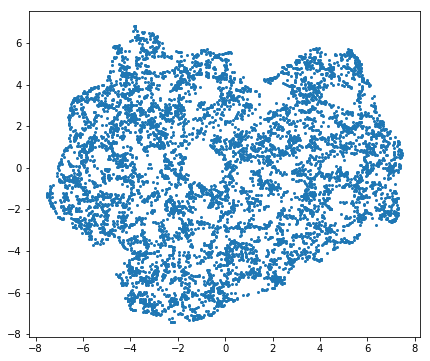

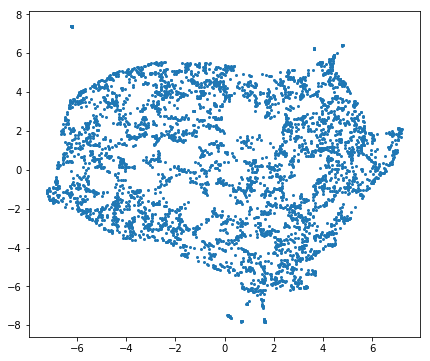

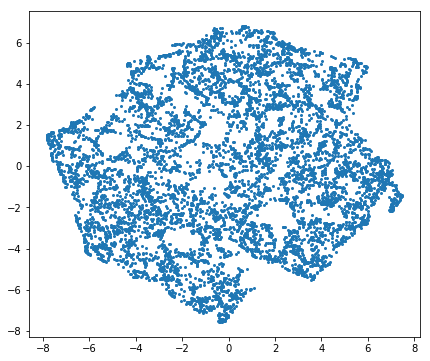

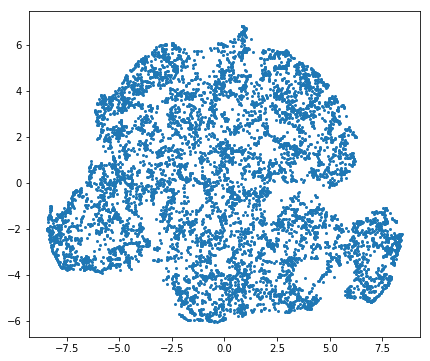

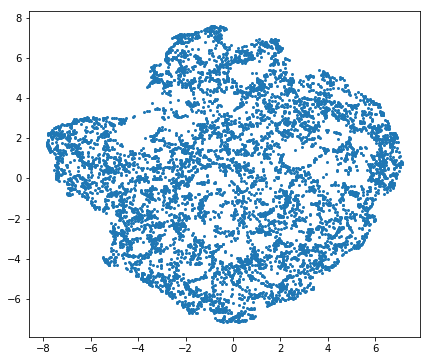

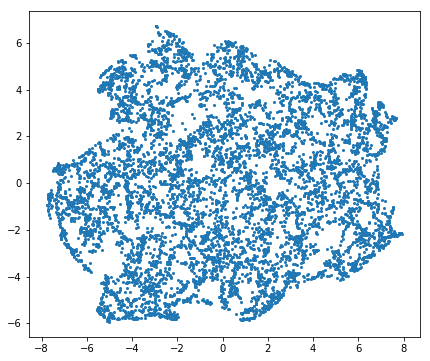

In [16]:
for embedding, file_ in zip(dl_conv_embedding_list, bed_list):
    print(file_)
    plot_embedding_2d(embedding)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed


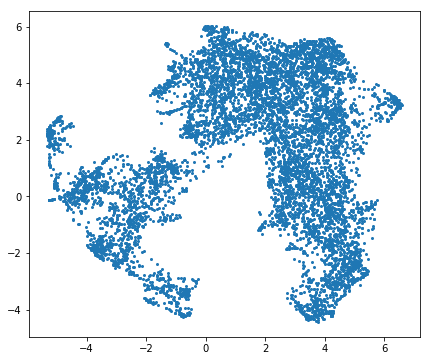

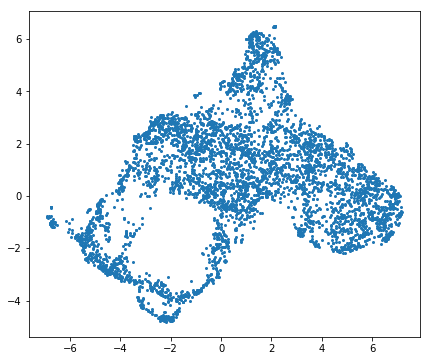

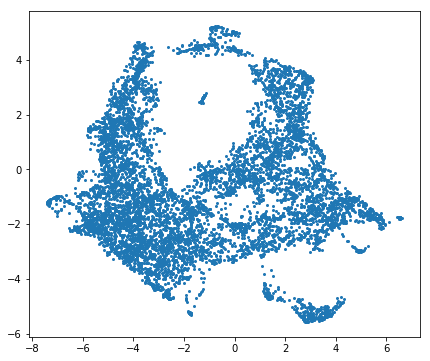

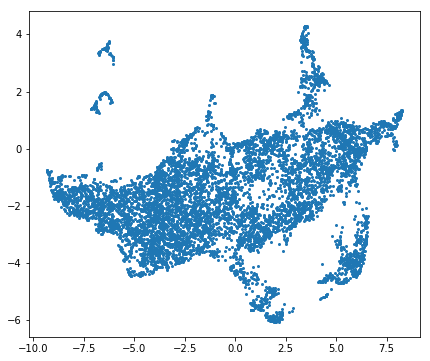

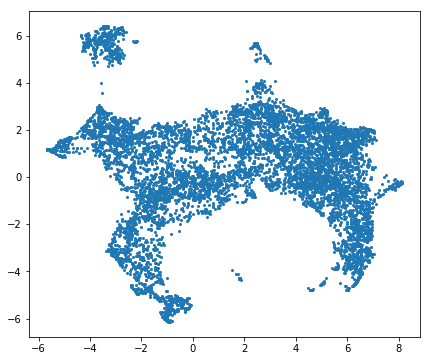

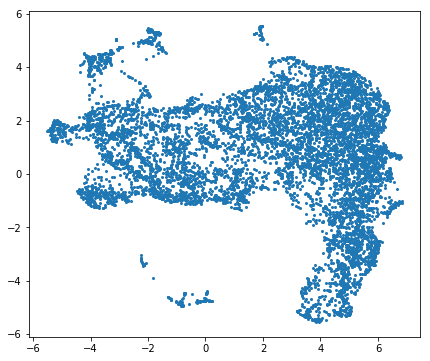

In [17]:
for embedding, file_ in zip(dl_fc_embedding_list, bed_list):
    print(file_)
    plot_embedding_2d(embedding)

In [18]:
#dl_conv_SSIndex_list = []
#for data in dl_conv_data_list:
#    N = np.shape(data)[0]
#    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
#    dl_conv_SSIndex_list.append(SubsetInds)

In [19]:
#dl_fc_SSIndex_list = []
#for data in dl_fc_data_list:
#    N = np.shape(data)[0]
#    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
#    dl_fc_SSIndex_list.append(SubsetInds)

In [52]:
k562_ccREs = BedTool('/data/locusselect/k562_annotations/K562-ccREs.bed10.hg19Lifted.bed')

In [76]:
histone_ccRESSIndex_list = []; histone_ccREIndex_list = []; histone_allccREIndex_list = []; histone_allccRESSIndex_list = [];
for data,bed in zip(dl_fc_data_list,dl_bed_list):
    N = np.shape(data)[0]
    myintersect = bed.intersect(k562_ccREs, u=True, f=0.5, r=True)
    a = [x for x in bed]
    b = [y for y in myintersect]
    c = []
    for ind,val in enumerate(a):
        if val in b:
            c.append(ind)
    ccRESubsetInds,ccREgains = selectSubset( data, n = ( N - len(c) ), distance = 'corr', initial_subset = c )
    histone_ccRESSIndex_list.append(ccRESubsetInds); histone_ccREIndex_list.append(c)

W0709 19:29:22.570751 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:29:22.584178 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:29:22.586439 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

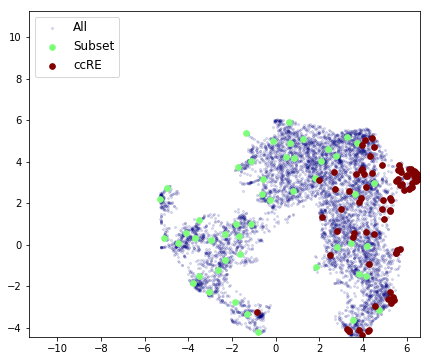

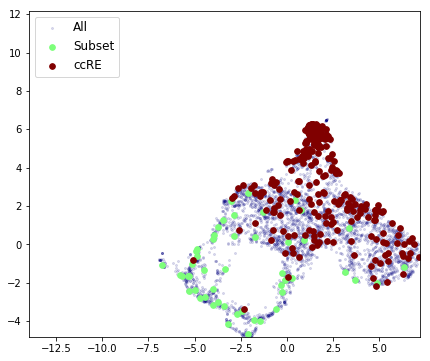

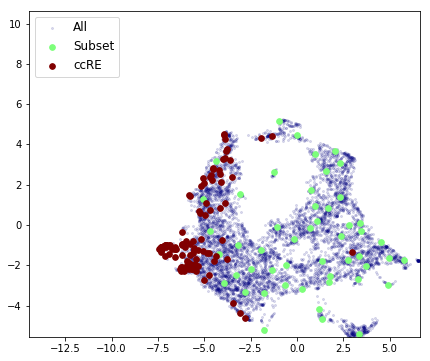

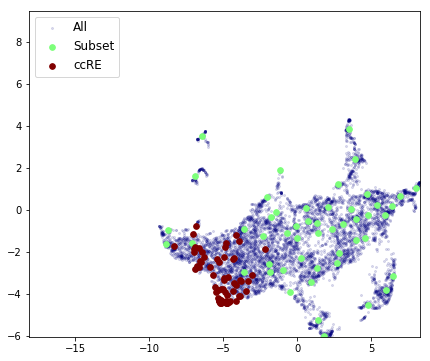

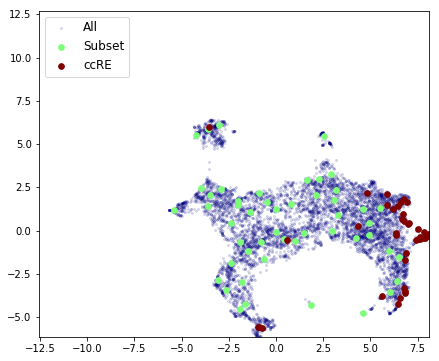

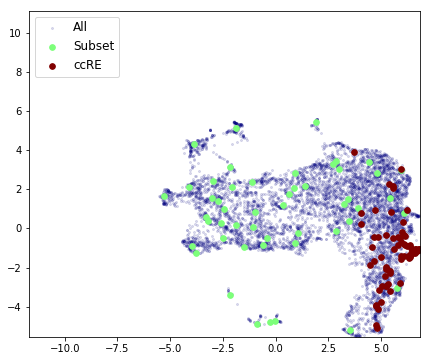

In [77]:
ss_size = 50
size_dict = { 'Subset' : 32, 'All' : 4, 'ccRE': 32 }
alpha_dict = { 'Subset' : 1, 'All' : 0.125, 'ccRE': 1 }

for SSIndex, embedding, ccRESSIndex, ix in zip (histone_ccREIndex_list,dl_fc_embedding_list,histone_ccRESSIndex_list, range(len(histone_ccRESSIndex_list))) :
    num_labels, label_dict = makeGeneralAnnotation ( [ccRESSIndex[0:ss_size], SSIndex], 
        ['Subset', 'ccRE'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict)

In [78]:
histone_ccRESSIndex_list = []; histone_ccREIndex_list = []; histone_allccREIndex_list = []; histone_allccRESSIndex_list = [];
for data,bed in zip(dl_conv_data_list,dl_bed_list):
    N = np.shape(data)[0]
    myintersect = bed.intersect(k562_ccREs, u=True, f=0.5, r=True)
    a = [x for x in bed]
    b = [y for y in myintersect]
    c = []
    for ind,val in enumerate(a):
        if val in b:
            c.append(ind)
    ccRESubsetInds,ccREgains = selectSubset( data, n = ( N - len(c) ), distance = 'corr', initial_subset = c )
    histone_ccRESSIndex_list.append(ccRESubsetInds); histone_ccREIndex_list.append(c)

W0709 19:34:29.389746 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:34:29.403385 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:34:29.405599 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

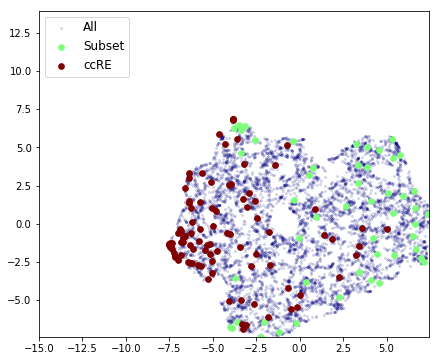

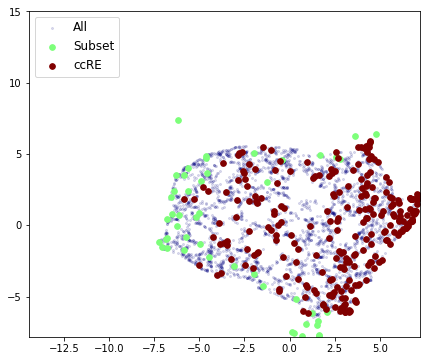

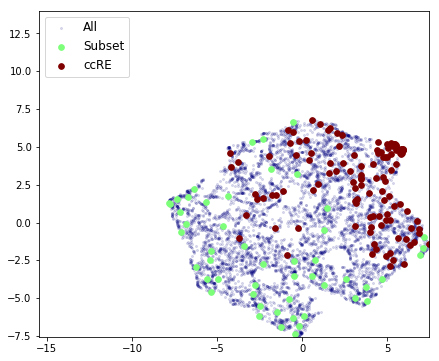

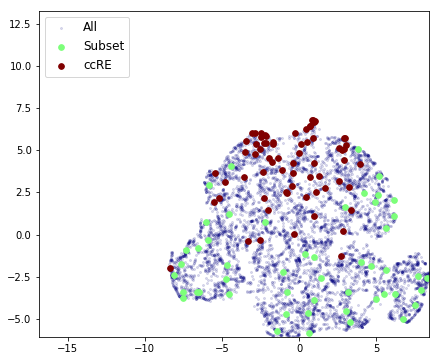

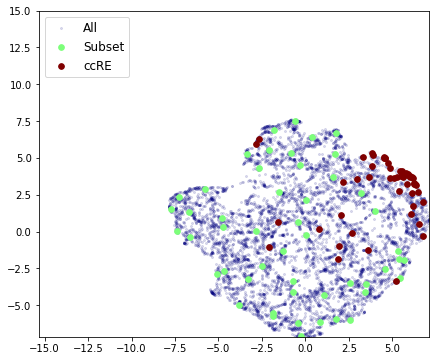

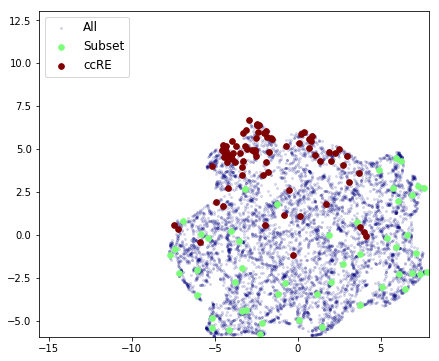

In [79]:
ss_size = 50
size_dict = { 'Subset' : 32, 'All' : 4, 'ccRE': 32 }
alpha_dict = { 'Subset' : 1, 'All' : 0.125, 'ccRE': 1 }

for SSIndex, embedding, ccRESSIndex, ix in zip (histone_ccREIndex_list,dl_conv_embedding_list,histone_ccRESSIndex_list, range(len(histone_ccRESSIndex_list))) :
    num_labels, label_dict = makeGeneralAnnotation ( [ccRESSIndex[0:ss_size], SSIndex], 
        ['Subset', 'ccRE'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict)

In [19]:
#dl_conv2_data_list = get_embedding_data_list_conv(bed_list, 9)

W0709 17:07:38.703428 140443288545088 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 17:07:38.716424 140443288545088 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 17:07:38.735338 140443288545088 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 17:07:38.735847 140443288545088 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 17:07:38.

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
9


W0709 17:07:39.048702 140443288545088 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0709 17:07:39.954494 140443288545088 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 17:07:39.967635 140443288545088 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 83, 200)        660200    
_________

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


9/9 [==============================] - 5s 591ms/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
9
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0 

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


5/5 [==============================] - 7s 1s/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
9
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0    

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


9/9 [==============================] - 8s 924ms/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
9
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0 

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


9/9 [==============================] - 7s 782ms/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
9
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0 

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


9/9 [==============================] - 7s 814ms/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed
9
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 250, 300)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 83, 300)        0 

/users/soumya.kundu/locusselect/locusselect/embeddings/__init__.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("gl...)`
  new_model = Model(input = model.input, output = flat_embedding)


9/9 [==============================] - 7s 813ms/step
got embeddings
got region labels


In [20]:
#with open('dl_conv2_data_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv2_data_list, fp)

In [80]:
with open ('dl_conv2_data_list.pickle', 'rb') as fp:
    dl_conv2_data_list = pickle.load(fp)

In [81]:
#dl_conv2_embedding_list = performEmbeddings(dl_conv2_data_list,metric=distanceMeasure)

In [24]:
#with open('dl_conv2_embedding_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv2_embedding_list, fp)

In [82]:
with open ('dl_conv2_embedding_list.pickle', 'rb') as fp:
    dl_conv2_embedding_list = pickle.load(fp)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed


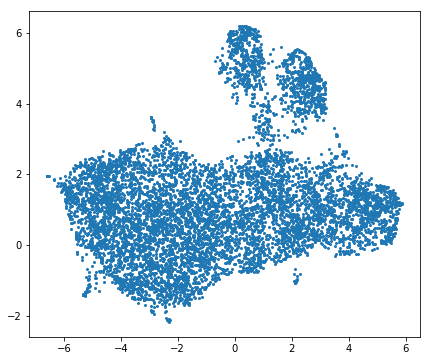

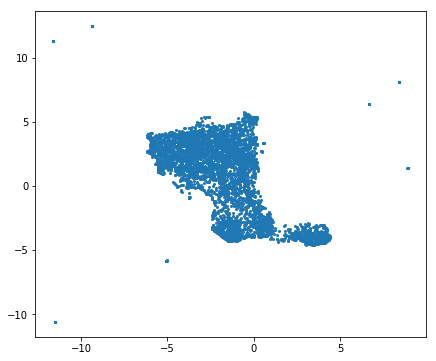

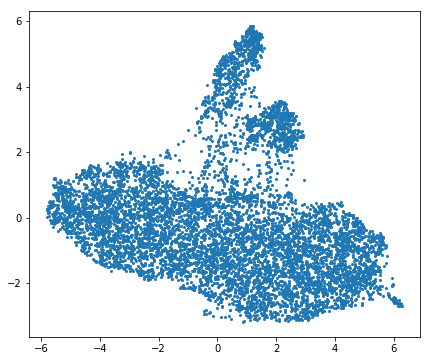

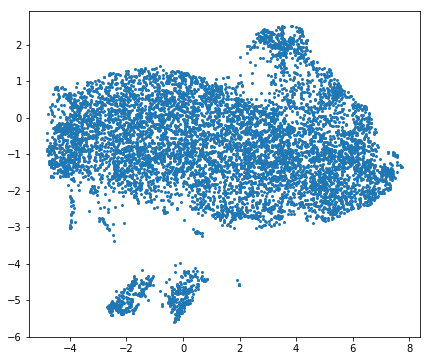

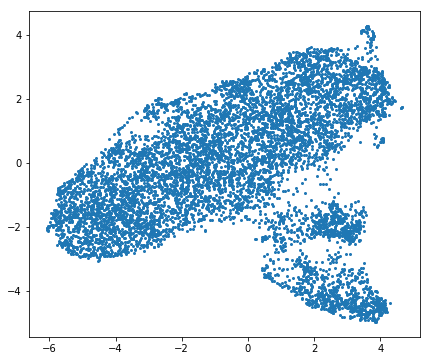

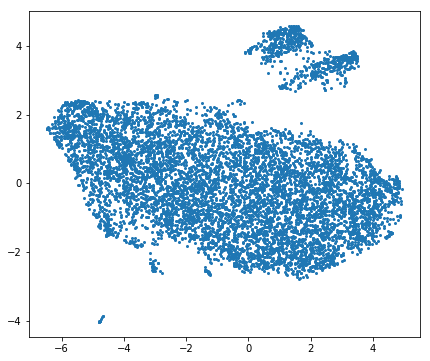

In [83]:
for embedding, file_ in zip(dl_conv2_embedding_list, bed_list):
    print(file_)
    plot_embedding_2d(embedding)

In [84]:
histone_ccRESSIndex_list = []; histone_ccREIndex_list = []; histone_allccREIndex_list = []; histone_allccRESSIndex_list = [];
for data,bed in zip(dl_conv2_data_list,dl_bed_list):
    N = np.shape(data)[0]
    myintersect = bed.intersect(k562_ccREs, u=True, f=0.5, r=True)
    a = [x for x in bed]
    b = [y for y in myintersect]
    c = []
    for ind,val in enumerate(a):
        if val in b:
            c.append(ind)
    ccRESubsetInds,ccREgains = selectSubset( data, n = ( N - len(c) ), distance = 'corr', initial_subset = c )
    histone_ccRESSIndex_list.append(ccRESubsetInds); histone_ccREIndex_list.append(c)

W0709 19:47:20.127480 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:47:20.141275 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0709 19:47:20.143472 140366769096512 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

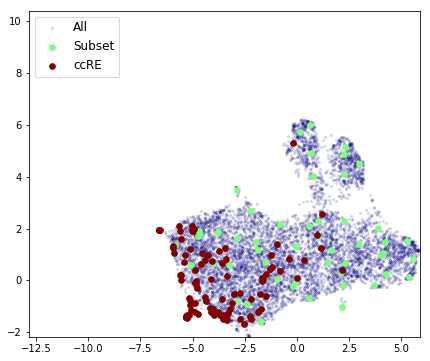

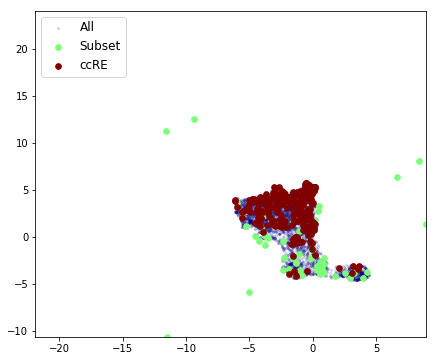

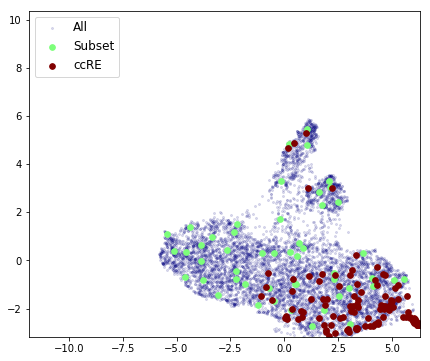

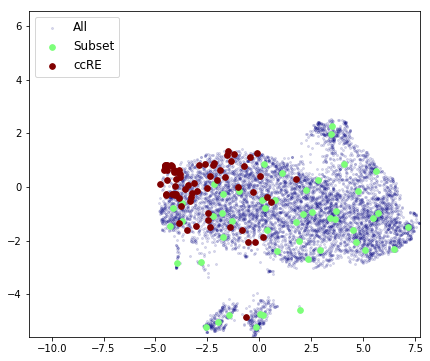

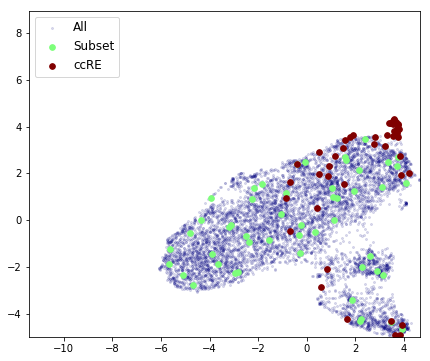

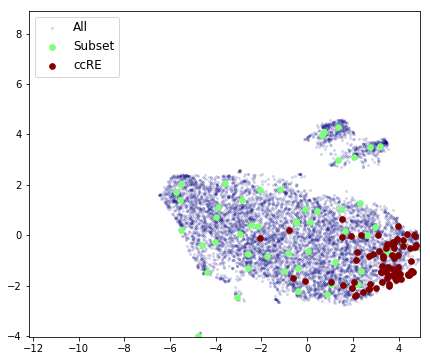

In [85]:
ss_size = 50
size_dict = { 'Subset' : 32, 'All' : 4, 'ccRE': 32 }
alpha_dict = { 'Subset' : 1, 'All' : 0.125, 'ccRE': 1 }

for SSIndex, embedding, ccRESSIndex, ix in zip (histone_ccREIndex_list,dl_conv2_embedding_list,histone_ccRESSIndex_list, range(len(histone_ccRESSIndex_list))) :
    num_labels, label_dict = makeGeneralAnnotation ( [ccRESSIndex[0:ss_size], SSIndex], 
        ['Subset', 'ccRE'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict)

In [40]:
gkm_list = ['/data/locusselect/gkmexplain/'+x for x in os.listdir('/data/locusselect/gkmexplain/') if x.startswith('gkmexplain.coord.embeddings.')]
gkm_data_list = []
for i in gkm_list:
    gkm_data_list.append(np.loadtxt(i))

In [41]:
gkm_data_list[0].shape

(8001, 5120)

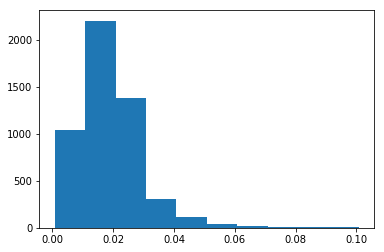

In [47]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.std((gkm_data_list[0]), axis=0))
plt.show()

In [49]:
topN = 1000

reduced_gkm_embeddings = []
for embedding in gkm_data_list:
    variance_across_sequences = np.std((gkm_data_list[0]), axis=0)
    indices_sorted_by_variance = [x[0] for x in sorted(enumerate(variance_across_sequences),
                                        key=lambda x: -x[1])]
    topN_indices = indices_sorted_by_variance[:topN]
    reduced_embedding = embedding[:,topN_indices]
    print(reduced_embedding.shape)
    reduced_gkm_embeddings.append(reduced_embedding)

(8001, 1000)
(8001, 1000)
(8001, 1000)
(8001, 1000)
(8001, 1000)
(4652, 1000)


In [50]:
gkm_embedding_list = performEmbeddings(reduced_gkm_embeddings,metric=distanceMeasure)

In [53]:
histone_ccRESSIndex_list = []; histone_ccREIndex_list = []; histone_allccREIndex_list = []; histone_allccRESSIndex_list = [];
for data,bed in zip(gkm_data_list,dl_bed_list):
    N = np.shape(data)[0]
    myintersect = bed.intersect(k562_ccREs, u=True, f=0.5, r=True)
    a = [x for x in bed]
    b = [y for y in myintersect]
    c = []
    for ind,val in enumerate(a):
        if val in b:
            c.append(ind)
    ccRESubsetInds,ccREgains = selectSubset( data, n = ( N - len(c) ), distance = 'corr', initial_subset = c )
    histone_ccRESSIndex_list.append(ccRESubsetInds); histone_ccREIndex_list.append(c)

ValueError: When passing in an integer mask for the initial subset the maximum value cannot exceed the size of the data set.

In [ ]:
ss_size = 50
size_dict = { 'Subset' : 32, 'All' : 4, 'ccRE': 32 }
alpha_dict = { 'Subset' : 1, 'All' : 0.125, 'ccRE': 1 }

for SSIndex, embedding, ccRESSIndex, ix in zip (histone_ccREIndex_list,gkm_embedding_list,histone_ccRESSIndex_list, range(len(histone_ccRESSIndex_list))) :
    num_labels, label_dict = makeGeneralAnnotation ( [ccRESSIndex[0:ss_size], SSIndex], 
        ['Subset', 'ccRE'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict)